In [1]:
import os
os.chdir('/content')
!git clone https://github.com/kimkim00/kimkim00.github.io

Cloning into 'kimkim00.github.io'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 4), reused 19 (delta 2), pack-reused 0
Unpacking objects: 100% (24/24), done.


# Import các thư viện

In [2]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D
from keras.layers import Dropout, Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import backend as K
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Tải model Pretrained model Word2Vec

In [3]:
import requests
url='https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz'
r = requests.get(url, allow_redirects=True)

open('cc.vi.300.vec.gz','wb').write(r.content)

1235219084

# extract file gzip chứa model Word2Vec

In [4]:
import gzip

def gunzip(source_filepath, dest_filepath, block_size=65536):
    with gzip.open(source_filepath, 'rb') as s_file, \
            open(dest_filepath, 'wb') as d_file:
        while True:
            block = s_file.read(block_size)
            if not block:
                break
            else:
                d_file.write(block)
gunzip('/content/cc.vi.300.vec.gz','/content/cc.vi.300.vec')

In [5]:
EMBEDDING_FILE = '/content/cc.vi.300.vec'


# Đọc dữ liệu (sents, sentiments, topics)

In [6]:
senti_train = pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/train/sentiments.txt',names=('s'))
sents_train = pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/train/sents.txt',names=('s'))
topics_train = pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/train/topics.txt',names=('t'))

senti_dev = pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/dev/sentiments.txt',names=('s'))
sents_dev = pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/dev/sents.txt',names=('s'))
topics_dev = pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/dev/topics.txt',names=('t'))

senti_test =pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/test/sentiments.txt',names=('s'))
sents_test =pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/test/sents.txt',names=('s'))
topics_test=pd.read_table('/content/kimkim00.github.io/_UIT-VSFC/test/topics.txt',names=('t'))

In [7]:
X_test=sents_test['s']
y_test=pd.DataFrame({'s':senti_test['s'],'t':topics_test['t']})
X_dev=sents_dev['s']
y_dev=pd.DataFrame({'s':senti_dev['s'],'t':topics_dev['t']})
X_train=sents_train['s']
y_train=pd.DataFrame({'s':senti_train['s'],'t':topics_train['t']})

In [8]:
y_train=pd.get_dummies(data=y_train, columns=['s','t'])
y_dev=pd.get_dummies(data=y_dev, columns=['s','t'])
y_test=pd.get_dummies(data=y_test, columns=['s','t'])

# Tiền xử lý dữ liệu(Text Preprocessing)

In [9]:
max_features=2489
maxlen=150
embed_size=300

In [10]:
tokenizer = text.Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(X_train))

In [11]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_dev = tokenizer.texts_to_sequences(X_dev)

In [12]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
X_dev = sequence.pad_sequences(X_dev, maxlen=maxlen)
print("create vector")

create vector


In [13]:
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))

In [14]:
for word, i in word_index.items():
    if i >= max_features:
        continue
  
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Tạo và training model với Bi-LSTM

In [16]:
inp = Input(shape=(maxlen,))

x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = SpatialDropout1D(0.35)(x)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])

out = Dense(7, activation='sigmoid')(x)

model = Model(inp, out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

In [17]:
batch_size = 32
epochs =3

history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), batch_size=batch_size, epochs=epochs, verbose=1)
predictions = model.predict(X_test, batch_size=batch_size, verbose=1)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11426 samples, validate on 1583 samples
Epoch 1/3
11426/11426 [==============================] - 329s 29ms/step - loss: 0.2397 - acc: 0.9012 - f1_m: 0.8225 - precision_m: 0.8520 - recall_m: 0.7970 - val_loss: 0.1675 - val_acc: 0.9363 - val_f1_m: 0.8849 - val_precision_m: 0.9140 - val_recall_m: 0.8580
Epoch 2/3
11426/11426 [==============================] - 323s 28ms/step - loss: 0.1585 - acc: 0.9396 - f1_m: 0.8923 - precision_m: 0.9108 - recall_m: 0.8749 - val_loss: 0.1577 - val_acc: 0.9413 - val_f1_m: 0.8958 - val_precision_m: 0.9070 - val_recall_m: 0.8851
Epoch 3/3
3166/3166 [==============================] - 6s 2ms/step


# Đánh giá model

In [18]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test metrics:', score)

3166/3166 [==============================] - 6s 2ms/step
Test metrics: [0.16513450407033017, 0.9380472898483276, 0.889352560043335, 0.9067339897155762, 0.872958779335022]


In [19]:
result = y_test.copy()
result[['s_0', 's_1', 's_2', 't_0', 't_1', 't_2', 't_3']] = predictions
result['sentiment_label']=0
result['topic_label']=0

from sklearn.metrics import classification_report
y_pred_s = np.argmax(np.array(result[['s_0','s_1','s_2']]), axis=1)
y_pred_t = np.argmax(np.array(result[['t_0','t_1','t_2','t_3']]), axis=1)
y_pred_bool= pd.DataFrame({'sentiments_label':y_pred_s,'topic_label':y_pred_t})

y_pred_bool.to_csv('result.csv')
model_json = model.to_json()
with open("model_num_bc.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

print(classification_report(y_test, pd.get_dummies(data=y_pred_bool, columns=['sentiments_label','topic_label'])))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1409
           1       0.57      0.25      0.35       167
           2       0.92      0.94      0.93      1590
           3       0.93      0.94      0.93      2290
           4       0.73      0.80      0.76       572
           5       0.96      0.89      0.92       145
           6       0.59      0.40      0.48       159

   micro avg       0.89      0.89      0.89      6332
   macro avg       0.80      0.74      0.76      6332
weighted avg       0.89      0.89      0.89      6332
 samples avg       0.89      0.89      0.89      6332



# Visualizing loss và accuracy

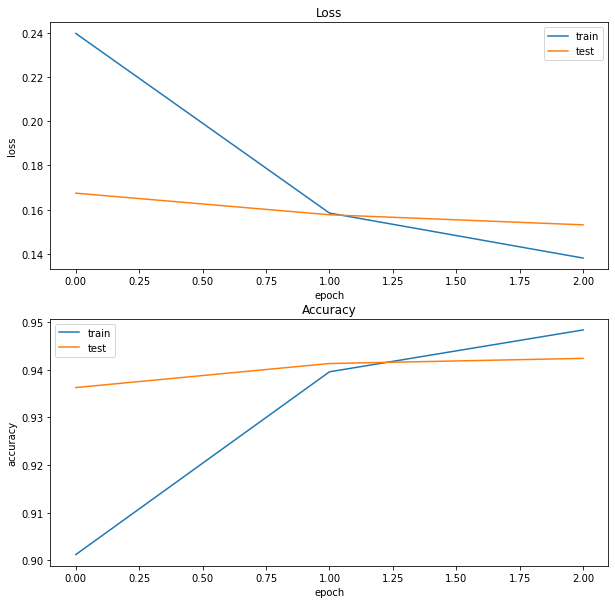

In [20]:
# plot loss during training
plt.figure(figsize=[10,10])
plt.subplot(211)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()